DA24C026 - Assignment 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_circles
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

Generating Dataset

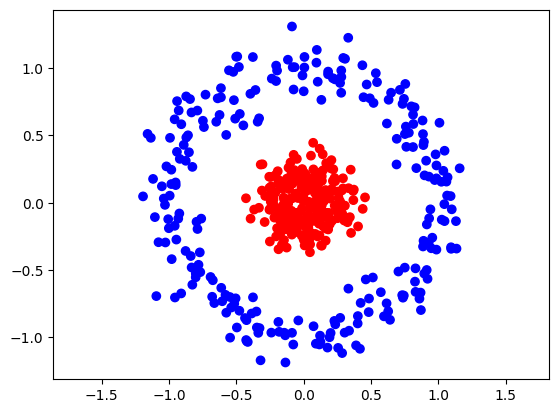

In [2]:
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"]))
plt.axis('equal')
plt.show()

TASK 1

ADABOOST Implementation from Scratch

In [3]:
class AdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, eta=0.5, base_estimator=None):
        
        self.n_estimators = n_estimators
        self.eta = eta
        self.alphas = []
        self.classifiers = []
        self.base_estimator = base_estimator

    def fit(self, X, y):
        
        n = X.shape[0]
        w = np.ones(n) / n                                                           # Initial weights set to average

        self.alphas = []
        self.classifiers = []

        for t in range(self.n_estimators):
            classifier = clone(self.base_estimator)
            ind = np.random.choice(len(X), size=len(X), replace=True, p=w)          # Sampling with replacement
            X_t, y_t = X[ind], y[ind]

            if len(np.unique(y_t)) < 2:
              continue

            classifier.fit(X_t, y_t)                
            predictions = classifier.predict(X)

            error_t = np.sum(w[predictions != y])                                    # Calculating errors / misclassifications

            if error_t > 0.5:
                alpha_t = 10^(-6)

            alpha_t = self.eta * np.log((1 - error_t) / error_t)                     

            w[predictions != y] *= np.exp(alpha_t)
            w[predictions == y] *= np.exp(-alpha_t)

            w = w / np.sum(w)                                                         # Weights Update

            self.alphas.append(alpha_t)
            self.classifiers.append(classifier)

    def predict(self, X):
        final_prediction = np.zeros(X.shape[0])
        for alpha, clf in zip(self.alphas, self.classifiers):
            final_prediction += alpha * clf.predict(X)
        return np.sign(final_prediction)

Functions for plotting graphs

In [4]:
def plot_all_iteration(model, X, y):

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx_, yy_ = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))


    plt.figure(figsize=(8, 6))

    for iteration, classifier in enumerate(model.classifiers, start=1):
        Z = classifier.predict(np.c_[xx_.ravel(), yy_.ravel()])
        Z = Z.reshape(xx_.shape)

        # Plot each classifier's decision boundary with increasing transparency
        plt.contour(xx_, yy_, Z, alpha=0.05, cmap=ListedColormap(['#00FFFF', '#FF00FF']))

    # Scatter plot of the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['green', 'yellow']), edgecolor='k', s=15)
    plt.title("Decision Boundaries from All Iterations")
    plt.show()


In [5]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx_, yy_ = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx_.ravel(), yy_.ravel()])
    Z = Z.reshape(xx_.shape)

    # Plot the final ensemble's decision boundary
    plt.contourf(xx_, yy_, Z, alpha=0.25, cmap=ListedColormap(['#00FFFF', '#FF00FF']))

    # Scatter plot of the points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['blue', 'red']), edgecolor='k', s=15)
    plt.title("Final Decision Boundary")

    plt.show()

TASK 2

Logistic Regression Implementation using Adaboost

In [31]:
param_grid = {
    'eta': [0.2,0.4,0.6,0.8, 1],
    'n_estimators': [100, 125, 150],
    'base_estimator__C': [0.01, 0.1, 1],
    'base_estimator__solver': ['lbfgs', 'liblinear'] }

In [32]:
classifier = AdaBoost(base_estimator = LogisticRegression())
grid_search = GridSearchCV(classifier, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_model)

Best Parameters: {'base_estimator__C': 0.01, 'base_estimator__solver': 'lbfgs', 'eta': 0.4, 'n_estimators': 150}
Best Estimator: AdaBoost(base_estimator=LogisticRegression(C=0.01), eta=0.4, n_estimators=150)


In [8]:
y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("Accuracy of Adaboost model with Logistic Regression is :",accuracy)

Accuracy of Adaboost model with Logistic Regression is : 1.0


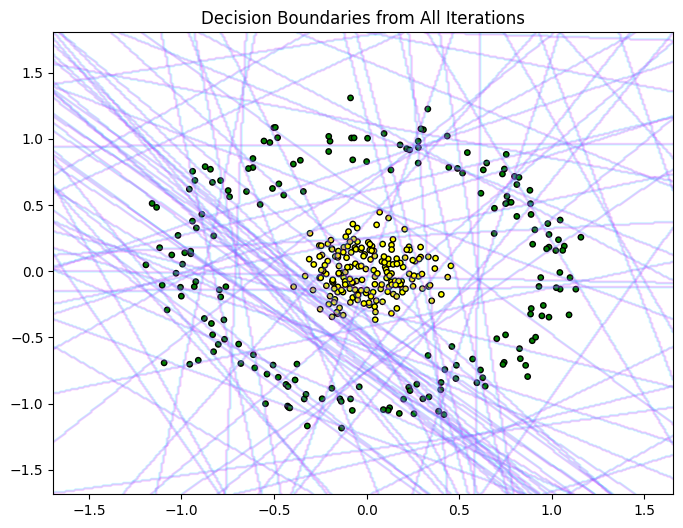

In [9]:
plot_all_iteration(model=best_model, X=X_train, y = y_train)

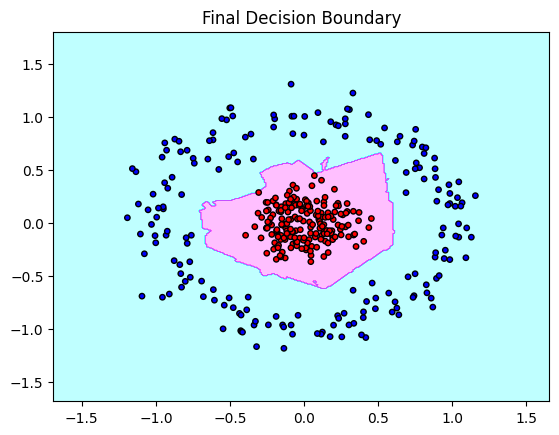

In [10]:
plot_decision_boundary(model=best_model, X=X_train, y = y_train)

Decision Stump Implementation using Adaboost

In [11]:
param_grid = {
    'eta': [0.2, 0.4, 0.6, 0.8, 1],
    'n_estimators': [50, 75, 100],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 5],
    'base_estimator__criterion': ['gini', 'entropy']
}

In [12]:
classifier = AdaBoost(base_estimator = DecisionTreeClassifier(max_depth=1))
grid_search = GridSearchCV(classifier, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_model)

Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'eta': 0.6, 'n_estimators': 100}
Best Estimator: AdaBoost(base_estimator=DecisionTreeClassifier(max_depth=1), eta=0.6,
         n_estimators=100)


In [13]:
y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("Accuracy of Adaboost model with Decision Stump is :",accuracy)

Accuracy of Adaboost model with Decision Stump is : 1.0


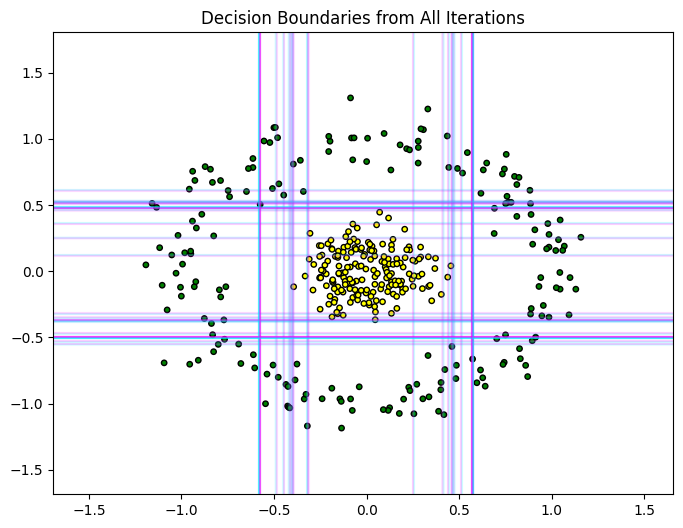

In [14]:
plot_all_iteration(model=best_model, X=X_train, y = y_train)

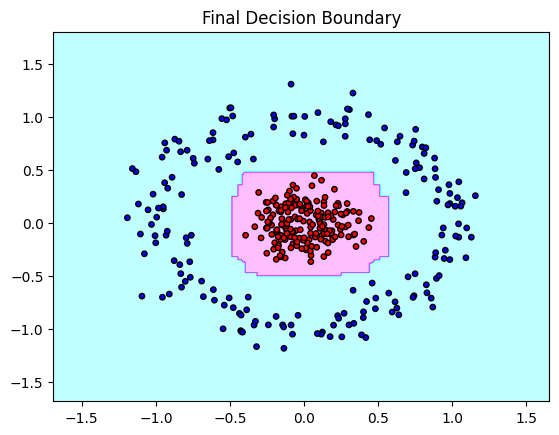

In [15]:
plot_decision_boundary(model=best_model, X=X_train, y = y_train)

Decision Tree (Max Depth = 3) Implementation using Adaboost

In [16]:
param_grid = {
    'eta': [0.2, 0.4, 0.6, 0.8, 1],
    'n_estimators': [50, 75, 100],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 5],
    'base_estimator__criterion': ['gini', 'entropy']
}

In [17]:
classifier = AdaBoost(base_estimator = DecisionTreeClassifier(max_depth=3))
grid_search = GridSearchCV(classifier, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_model)

Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'eta': 0.4, 'n_estimators': 75}
Best Estimator: AdaBoost(base_estimator=DecisionTreeClassifier(max_depth=3), eta=0.4,
         n_estimators=75)


In [18]:
y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("Accuracy of Adaboost model with Decision Tree is :",accuracy)

Accuracy of Adaboost model with Decision Tree is : 1.0


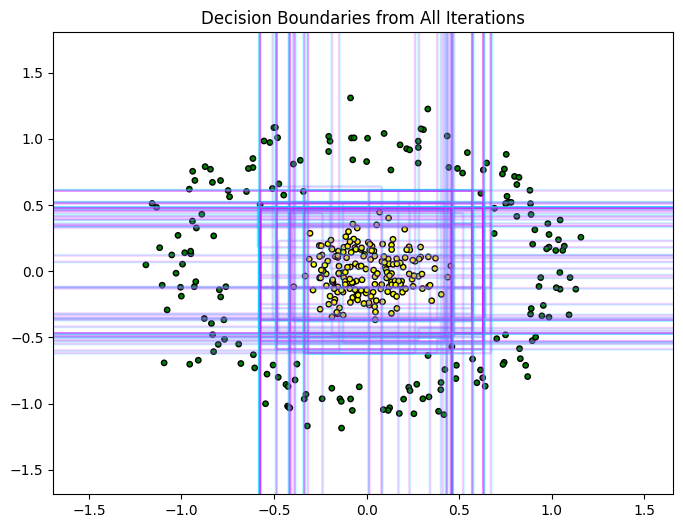

In [19]:
plot_all_iteration(model=best_model, X=X_train, y = y_train)

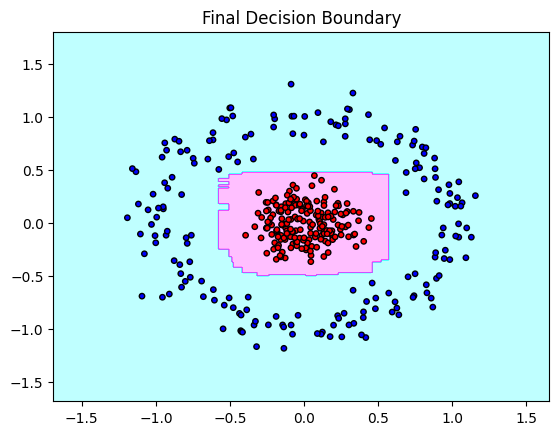

In [20]:
plot_decision_boundary(model=best_model, X=X_train, y = y_train)

Linear SVM Implementation using Adaboost

In [21]:
param_grid = {
    'eta': [0.2, 0.4, 0.6, 0.8, 1],
    'n_estimators': [50, 75, 100],
    'base_estimator__C': [0.01, 0.1, 1,10],
    'base_estimator__loss': ['hinge', 'squared_hinge']
}

In [22]:
classifier = AdaBoost(base_estimator = LinearSVC())
grid_search = GridSearchCV(classifier, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_model)

Best Parameters: {'base_estimator__C': 0.1, 'base_estimator__loss': 'hinge', 'eta': 0.8, 'n_estimators': 100}
Best Estimator: AdaBoost(base_estimator=LinearSVC(C=0.1, loss='hinge'), eta=0.8,
         n_estimators=100)


In [23]:
y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("Accuracy of Adaboost model with Linear SVM is :",accuracy)

Accuracy of Adaboost model with Linear SVM is : 1.0


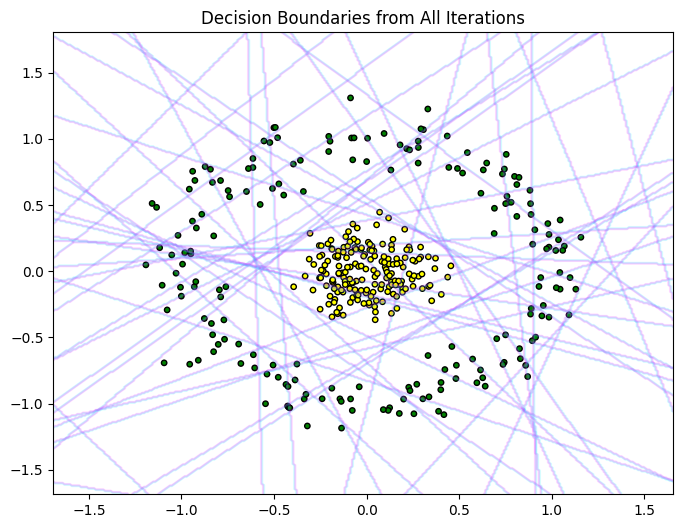

In [24]:
plot_all_iteration(model=best_model, X=X_train, y = y_train)

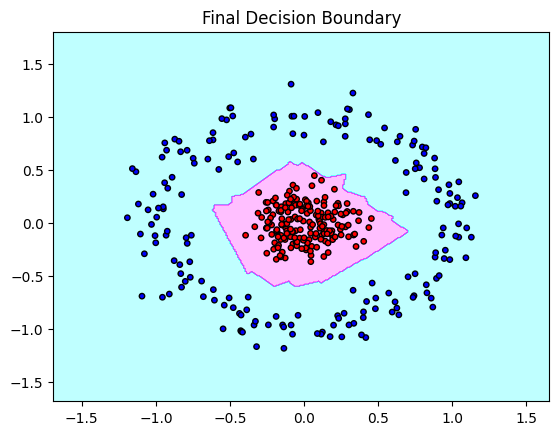

In [25]:
plot_decision_boundary(model=best_model, X=X_train, y = y_train)

LDA implementation using AdaBoost

In [26]:
param_grid = {
    'eta': [0.2, 0.4, 0.6, 0.8, 1],  
    'n_estimators': [150, 175, 200],   
    'base_estimator__solver': ['svd', 'lsqr', 'eigen'],  
    }

In [27]:
classifier = AdaBoost(base_estimator = LDA())
grid_search = GridSearchCV(classifier, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_model)

Best Parameters: {'base_estimator__solver': 'svd', 'eta': 0.8, 'n_estimators': 200}
Best Estimator: AdaBoost(base_estimator=LinearDiscriminantAnalysis(), eta=0.8, n_estimators=200)


In [28]:
y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print("Accuracy of Adaboost model with LDA is :",accuracy)

Accuracy of Adaboost model with LDA is : 0.992


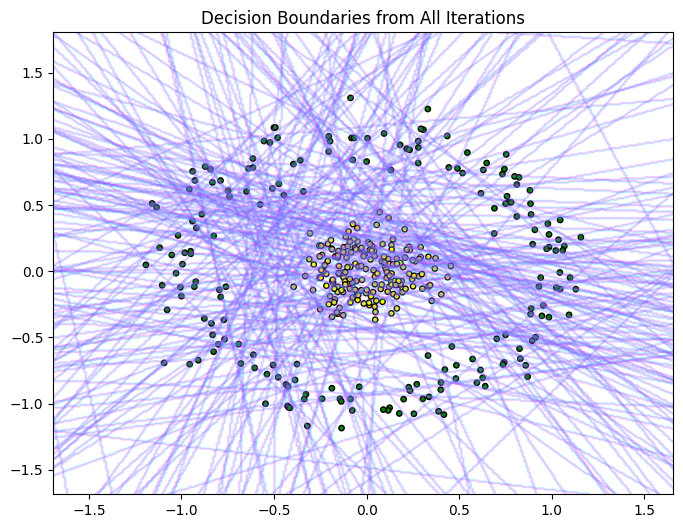

In [29]:
plot_all_iteration(model = best_model, X = X_train, y = y_train)

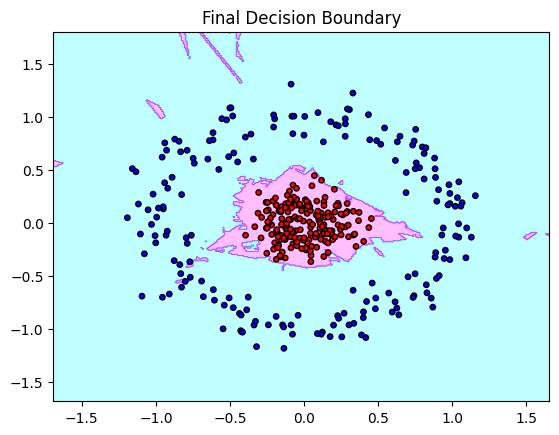

In [30]:
plot_decision_boundary(model=best_model, X = X_train, y = y_train)